В первой части задания по анализу фондового рынка Германии за 2018 был рассмотрен индекс DAX - главный индекс немецкого фондового рынка, который включает в себя 30 крупнейших и наиболее ликвидных компаний, зарегистрированных на Франкфуртской фондовой бирже. Для данной части работы 50 акций были выбраны из индекса MDAX (Mid-Cap DAX) - индекса, который включает в себя 50 компаний среднего размера, следующих за DAX по рыночной капитализации. Он отражает динамику средних компаний в Германии. С учётом того, что 3 акции из выбранных начали торги после 2018 года, они были заменены 3 акциями из индекса SDAX (Small-Cap DAX) - индекса, который включает в себя 70 малых компаний, которые не входят в MDAX. (Эти акции последние в списке dax_tickers)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy import interpolate

Подготовка данных

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

dax_tickers = [
    "AIXA.DE", "AT1.DE", "NDA.DE",  "BC8.DE", "BFSA.DE", "GBF.DE",  "AFX.DE",  "EVD.DE", "DHER.DE", "LHA.DE",
    "ECV.DE",  "EVT.DE", "EVK.DE",  "FRA.DE", "FNTN.DE", "FRE.DE",  "FPE3.DE", "G1A.DE", "GXI.DE",  "HLE.DE",
    "HFG.DE",  "HOT.DE", "BOSS.DE", "JEN.DE", "JUN3.DE", "SDF.DE",  "LXS.DE",  "KRN.DE", "KGX.DE",  "KBX.DE",
    "LEG.DE",  "NEM.DE", "NDX1.DE", "PUM.DE", "RAA.DE",  "RDC.DE",  "RRTL.DE", "G24.DE", "WAF.DE",  "STM.DE",
    "SAX.DE",  "TEG.DE", "TLX.DE",  "TKA.DE", "TUI1.DE", "UTDI.DE", "WCH.DE",  "1U1.DE", "ADN1.DE", "AAD.DE"
]
dax_tickers.sort()

data_frames = []

for ticker in dax_tickers:
    data = yf.download(ticker, start="2018-01-01", end="2018-12-31")
    data['Ticker'] = ticker
    data_frames.append(data[['Open', 'High', 'Low', 'Close', 'Ticker']])

all_data = pd.concat(data_frames)
all_data.reset_index(inplace=True)
all_data = all_data[['Date', 'Open', 'High', 'Low', 'Close', 'Ticker']]

#print(all_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
all_data['Return'] = all_data.groupby('Ticker')['Close'].pct_change()
all_data['Log_Return'] = np.where(
    all_data['Ticker'] == all_data['Ticker'].shift(1),
    np.log(all_data['Close'] / all_data['Close'].shift(1)),
    np.nan
)
returns = all_data.pivot(index='Date', columns='Ticker', values='Log_Return')

Прежде чем приступить к выполнению заданий и всем расчетам, посмотрим на корреляционную матрицу.

In [ ]:
corr_matrix = returns.corr().values
for i in range(corr_matrix.shape[0]):
  for j in range(i, corr_matrix.shape[0]):
    if (i != j and 0.5 <= corr_matrix[i][j] < 1.0):
      print(f"correlation {corr_matrix[i][j]:.2f} between {dax_tickers[i]} and {dax_tickers[j]}")

correlation 0.51 between 1U1.DE and FNTN.DE
correlation 0.68 between 1U1.DE and UTDI.DE
correlation 0.51 between ADN1.DE and KBX.DE
correlation 0.59 between AIXA.DE and WAF.DE
correlation 0.57 between AT1.DE and LEG.DE
correlation 0.53 between AT1.DE and TEG.DE
correlation 0.51 between BC8.DE and NEM.DE
correlation 0.51 between ECV.DE and SDF.DE
correlation 0.53 between EVK.DE and HLE.DE
correlation 0.52 between EVK.DE and JEN.DE
correlation 0.50 between EVK.DE and JUN3.DE
correlation 0.62 between EVK.DE and LXS.DE
correlation 0.52 between EVK.DE and SDF.DE
correlation 0.51 between EVK.DE and WCH.DE
correlation 0.50 between EVT.DE and KBX.DE
correlation 0.52 between HLE.DE and LXS.DE
correlation 0.58 between HLE.DE and STM.DE
correlation 0.53 between HLE.DE and WAF.DE
correlation 0.53 between JEN.DE and KBX.DE
correlation 0.50 between JEN.DE and LXS.DE
correlation 0.66 between JUN3.DE and KGX.DE
correlation 0.55 between JUN3.DE and LXS.DE
correlation 0.56 between KBX.DE and LXS.DE
corr

Как можно увидеть, некоторые активы имеют довольно высокую корреляцию с множеством активов. Это следущие активы: LXS.DE, KBX.DE, EVK.DE. Использование их в будущем может привести к проблемам с ковариационной матрицей. Поэтому просто исключим их из выборки.

In [ ]:
BLACKLIST = ["LXS.DE", "KBX.DE", "EVK.DE"]

all_data = all_data[all_data.Ticker.isin(BLACKLIST) == False].reset_index(drop=True)
for ticker in BLACKLIST:
  if (ticker in dax_tickers):
    dax_tickers.remove(ticker)

print("Список используемых далее активов:")
for ticker in dax_tickers:
  print(ticker)

Список используемых далее активов:
1U1.DE
AAD.DE
ADN1.DE
AFX.DE
AIXA.DE
AT1.DE
BC8.DE
BFSA.DE
BOSS.DE
DHER.DE
ECV.DE
EVD.DE
EVT.DE
FNTN.DE
FPE3.DE
FRA.DE
FRE.DE
G1A.DE
G24.DE
GBF.DE
GXI.DE
HFG.DE
HLE.DE
HOT.DE
JEN.DE
JUN3.DE
KGX.DE
KRN.DE
LEG.DE
LHA.DE
NDA.DE
NDX1.DE
NEM.DE
PUM.DE
RAA.DE
RDC.DE
RRTL.DE
SAX.DE
SDF.DE
STM.DE
TEG.DE
TKA.DE
TLX.DE
TUI1.DE
UTDI.DE
WAF.DE
WCH.DE


In [ ]:
returns = all_data.pivot(index='Date', columns='Ticker', values='Log_Return')
data = all_data[['Date', 'Close', 'Log_Return', 'Ticker']]
summary_stats = data.groupby('Ticker')['Log_Return'].agg(['mean', 'std']).reset_index()
means = summary_stats['mean'].values.reshape(-1, 1)
number = returns.shape[1]

print("Значения доходности и риска активов:")
print(summary_stats)
print()
print(f"Кол-во активов: {number}")

Значения доходности и риска активов:
     Ticker      mean       std
0    1U1.DE -0.001788  0.022513
1    AAD.DE  0.000074  0.015987
2   ADN1.DE -0.000611  0.020259
3    AFX.DE  0.001133  0.016555
4   AIXA.DE -0.001432  0.037983
5    AT1.DE  0.000388  0.012366
6    BC8.DE -0.000127  0.016492
7   BFSA.DE -0.000423  0.018487
8   BOSS.DE -0.001163  0.015979
9   DHER.DE -0.000020  0.021810
10   ECV.DE -0.000702  0.012483
11   EVD.DE -0.000694  0.017922
12   EVT.DE  0.000977  0.033622
13  FNTN.DE -0.002414  0.018077
14  FPE3.DE -0.000847  0.014874
15   FRA.DE -0.001553  0.013250
16   FRE.DE -0.001665  0.022394
17   G1A.DE -0.002267  0.020181
18   G24.DE  0.000668  0.017051
19   GBF.DE -0.001730  0.018317
20   GXI.DE -0.000761  0.016574
21   HFG.DE -0.002656  0.024208
22   HLE.DE -0.001573  0.019249
23   HOT.DE -0.000845  0.013839
24   JEN.DE -0.000793  0.025399
25  JUN3.DE -0.002154  0.021263
26   KGX.DE -0.001947  0.022514
27   KRN.DE -0.002067  0.020053
28   LEG.DE -0.000168  0.011156
29 

### 1. Портфель с минимальным риском
Для нахождения портфеля с минимальным риском потребуется решить задачу оптимизации, в которой расчеты производятся с помощью ковариационной матрицы, расчитанной на основе данных о доходностях активов. Поэтому, для начала, посчитаем эту матрицу.


In [ ]:
cov_dataframe = returns.cov()
cov_matrix = [[cov_dataframe[t1][t2] for t2 in dax_tickers] for t1 in dax_tickers]
cov_matrix = np.array(cov_matrix)

print(f"Определитель ковариационной матрицы: {np.linalg.det(cov_matrix)}")

Определитель ковариационной матрицы: 1.3639130818526751e-170


Как можно увидеть, значение определителя довольно маленькое, однако для вычислений с помощью солвера далее этого значения достаточно.

Теперь, зная ковариационную матрицу, найдем портфели с минимальным риском для случаев когда короткие продажи разрешены и запрещены. Напишем функцию, которая по заданным ограничениям и ковариационной матрице, будет находить портфель с минимальным риском. Воспользуемся встроенным в cvxpy солвером, чтобы решить задачу нелинейной оптимизации.

In [ ]:
def calc_min_volatility(proportion, constraints, cov_matrix):
  disp = cp.quad_form(proportion, cov_matrix)
  minim = cp.Minimize(disp)
  problem = cp.Problem(minim, constraints)
  problem.solve()
  sigma = disp.value ** 0.5

  return sigma

Функция выше возвращает значение волатильности минимального портфеля, а также находит вектор долей акций для этого портфеля. Теперь применим эту функцию для вычисления портфелей с минимальным риском.

Короткие продажи разрешены

In [ ]:
proportion_short = cp.Variable(number)  # Переменная для долей активов
constraints_short = [cp.sum(proportion_short) == 1]
sigma_short = calc_min_volatility(proportion_short, constraints_short, cov_matrix)
mean_short = (proportion_short.value.T @ means)[0]

print(f"Волатильность: {sigma_short:.6f}")
print(f"Доходность: {mean_short:.6f}")
print()

print("Доли активов в портфеле:")
result_short = dict(zip(returns.columns, proportion_short.value))
for ticker, prop in result_short.items():
  print(f"{ticker}: {prop:.6f}")

Волатильность: 0.005942
Доходность: -0.000569

Доли активов в портфеле:
1U1.DE: 0.002625
AAD.DE: 0.027673
ADN1.DE: 0.003951
AFX.DE: 0.009258
AIXA.DE: -0.009415
AT1.DE: -0.005464
BC8.DE: 0.001007
BFSA.DE: 0.094334
BOSS.DE: 0.065639
DHER.DE: 0.011828
ECV.DE: 0.090819
EVD.DE: 0.027407
EVT.DE: -0.028851
FNTN.DE: -0.009068
FPE3.DE: 0.044770
FRA.DE: 0.095482
FRE.DE: 0.015453
G1A.DE: -0.023313
G24.DE: -0.013353
GBF.DE: -0.003755
GXI.DE: 0.015148
HFG.DE: 0.009310
HLE.DE: 0.039799
HOT.DE: 0.012336
JEN.DE: -0.050384
JUN3.DE: -0.000350
KGX.DE: -0.028656
KRN.DE: 0.077985
LEG.DE: 0.093302
LHA.DE: 0.018171
NDA.DE: 0.018322
NDX1.DE: 0.000395
NEM.DE: -0.049620
PUM.DE: -0.025238
RAA.DE: 0.005354
RDC.DE: 0.047505
RRTL.DE: 0.080983
SAX.DE: -0.000960
SDF.DE: -0.052205
STM.DE: -0.031861
TEG.DE: 0.249319
TKA.DE: 0.005371
TLX.DE: 0.180990
TUI1.DE: 0.038200
UTDI.DE: -0.001539
WAF.DE: -0.051826
WCH.DE: 0.003120


Короткие продажи запрещены



In [ ]:
proportion_no_short = cp.Variable(number)  # Переменная для долей активов
constraints_no_short = [cp.sum(proportion_no_short) == 1,
                        proportion_no_short >= 0]
sigma_no_short = calc_min_volatility(proportion_no_short, constraints_no_short, cov_matrix)
mean_no_short = (proportion_no_short.value.T @ means)[0]

print(f"Волатильность: {sigma_no_short:.6f}")
print(f"Доходность: {mean_no_short:.6f}")
print()

print("Доли активов в портфеле:")
result_no_short = dict(zip(returns.columns, proportion_no_short.value))
for ticker, prop in result_no_short.items():
    if prop < 1e-16:
      print(f"{ticker}: {0.0}")
    else:
      print(f"{ticker}: {prop:.6f}")

Волатильность: 0.006858
Доходность: -0.000355

Доли активов в портфеле:
1U1.DE: 0.0
AAD.DE: 0.026870
ADN1.DE: 0.0
AFX.DE: 0.0
AIXA.DE: 0.0
AT1.DE: 0.024079
BC8.DE: 0.0
BFSA.DE: 0.081040
BOSS.DE: 0.036874
DHER.DE: 0.0
ECV.DE: 0.046666
EVD.DE: 0.005566
EVT.DE: 0.0
FNTN.DE: 0.0
FPE3.DE: 0.0
FRA.DE: 0.055256
FRE.DE: 0.0
G1A.DE: 0.0
G24.DE: 0.0
GBF.DE: 0.0
GXI.DE: 0.007498
HFG.DE: 0.0
HLE.DE: 0.0
HOT.DE: 0.0
JEN.DE: 0.0
JUN3.DE: 0.0
KGX.DE: 0.0
KRN.DE: 0.040408
LEG.DE: 0.098082
LHA.DE: 0.0
NDA.DE: 0.0
NDX1.DE: 0.0
NEM.DE: 0.0
PUM.DE: 0.0
RAA.DE: 0.0
RDC.DE: 0.049019
RRTL.DE: 0.079429
SAX.DE: 0.0
SDF.DE: 0.0
STM.DE: 0.0
TEG.DE: 0.251067
TKA.DE: 0.0
TLX.DE: 0.169950
TUI1.DE: 0.028196
UTDI.DE: 0.0
WAF.DE: 0.0
WCH.DE: 0.0


Выведем полученные портфели на графике

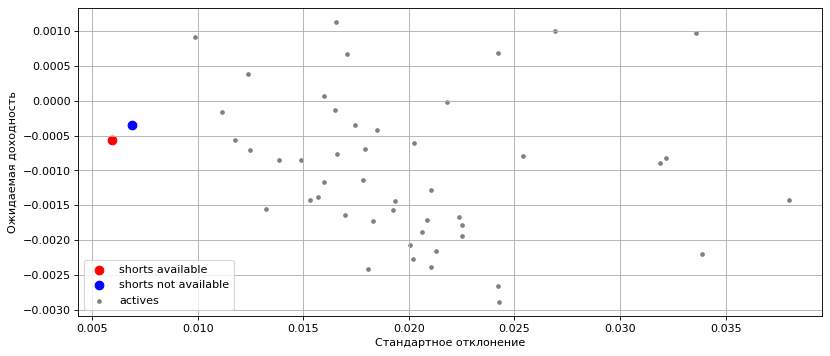

In [ ]:
plt.figure(figsize=(12, 5), dpi = 80)

# Короткие продажы разрешены
plt.scatter(sigma_short, mean_short, s=60, color = "red", label = "shorts available")

# Короткие продажы запрещены
plt.scatter(sigma_no_short, mean_no_short, s=60, color = "blue", label = "shorts not available")

# Активы
plt.scatter(summary_stats['std'], summary_stats['mean'], color = "grey", s=10, label="actives")

plt.xlabel('Стандартное отклонение')
plt.ylabel('Ожидаемая доходность')

plt.legend()
plt.grid()
plt.show()



---


Как можно увидеть из графика выше, минимальный портфель при запрете коротких продаж имеет большую доходность, но при этом и больший риск, относительно портфеля с разрешением коротких продаж.


---



### 2. Построение эффективного фронта
Сначала напишем функции для построения эффективных фронтов в случаях когда короткие продажи разрешены и запрещены. Нам нужно получить набор точек, чтобы по нему построить фронт. Для этого зададим начальное значение доходности *e0* и с некоторым шагом будем его увеличивать, считая портфель с минимальным риском для каждого значения *e0*.

Короткие продажи разрешены

In [ ]:
def efficient_frontier_short(e0, number, precision, means, cov_matrix, eps):
  x = np.array([])
  y = np.array([])
  for i in range(precision):
    e0 += eps
    proportion = cp.Variable(number)
    disp0 = cp.quad_form(proportion, cov_matrix)
    minim = cp.Minimize(disp0)
    constraints = [cp.sum(proportion) == 1,
                  proportion @ means == e0]
    problem = cp.Problem(minim, constraints)
    problem.solve(solver=cp.CLARABEL)
    sigma0 = disp0.value**0.5

    x = np.append(x, sigma0)
    y = np.append(y, e0)

  return x, y

Короткие продажи запрещены

In [ ]:
def efficient_frontier_no_short(e0, number, precision, means, cov_matrix, eps):
  x = np.array([])
  y = np.array([])
  for i in range(precision):
    e0 += eps
    proportion = cp.Variable(number)
    disp0 = cp.quad_form(proportion, cov_matrix)
    minim = cp.Minimize(disp0)
    constraints = [cp.sum(proportion) == 1,
                  proportion @ means == e0,
                  proportion >= 0]
    try:
      problem = cp.Problem(minim, constraints)
      problem.solve(solver=cp.CLARABEL)
      sigma0 = disp0.value**0.5
    except:
      break

    x = np.append(x, sigma0)
    y = np.append(y, e0)

  return x, y

Применим функции и получим два набора точек

In [ ]:
EPS_SHORT    = 1e-05  # Шаг доходности при разрешении коротких продажах
EPS_NO_SHORT = 1e-06  # Шаг доходности при запрете коротких продаж

In [ ]:
# Короткие продажи разрешены
x_short, y_short = efficient_frontier_short(mean_short, number, 1000, means, cov_matrix, EPS_SHORT)

# Короткие продажи запрещены
x_no_short, y_no_short = efficient_frontier_no_short(mean_no_short, number, 2000, means, cov_matrix, EPS_NO_SHORT)

Так же посчитаем портфель с равными долями у каждой акции, чтобы оценить его относительно эффективных фронтов

In [ ]:
x_equal = [1 / number] * number
sigma_equal = cp.quad_form(x_equal, cov_matrix).value ** 0.5
mean_equal = (sum(means) / number)[0]

print("Портфель с равными долями")
print(f"Волатильность портфеля: {sigma_equal:.6f}")
print(f"Доходность портфеля: {mean_equal:.6f}")

Портфель с равными долями
Волатильность портфеля: 0.010363
Доходность портфеля: -0.000991


Выведем все полученные данные на одном графике

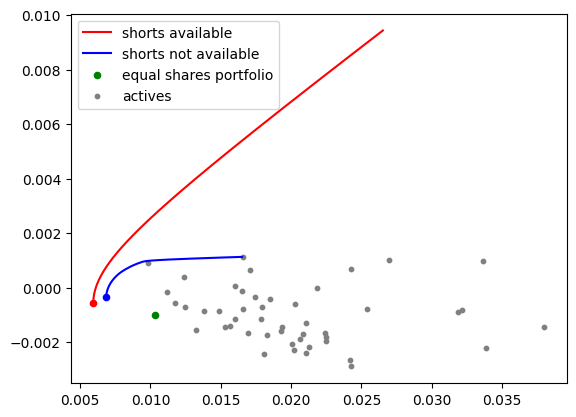

In [ ]:
fig, ax = plt.subplots()

# Короткие продажи разрешены
plt.scatter(sigma_short, mean_short, s=20, color = "red")
ax.plot(x_short, y_short, color = "red", label = "shorts available")

# Короткие продажи запрещены
plt.scatter(sigma_no_short, mean_no_short, s=20, color = "blue")
ax.plot(x_no_short, y_no_short, color = "blue", label = "shorts not available")

# Портфель с равными долями
plt.scatter(sigma_equal, mean_equal, s=20, color = "green", label="equal shares portfolio")

# Активы
plt.scatter(summary_stats['std'], summary_stats['mean'], color = "grey", s=10, label="actives")

plt.legend()
plt.show()



---


На полученном графике можно увидеть, что при запрете коротких продаж эффективный фронт заканчивается ровно в точке актива с наивысшим уровнем доходности. Если же короткие продажи разрешены, эффективный фронт не ограничен и уходит в бесконечность. Также можно увидеть, что портфель с равными долями оказался хуже (как по риску, так и по доходности), чем минимальные портфели, посчитанные путем решения задачи Лагранжа. И хоть он и находится не так далеко от них, рассматривать его в качестве основной стратегии не стоит, ведь есть и более выгодные решения, находящиеся на линии эффективного фронта.


---



### 3. Проблема выбора портфелей

В этой части задания нам нужно отобрать 10 активов из прошлых 47, чтобы для них так же построить эффективный фронт. Выберем 10 активов с самой высокой доходностью.

In [ ]:
tickers_with_max_e = np.array(summary_stats.sort_values('mean')[::-1][:10].Ticker)

print("Выбранные активы:")
for i in tickers_with_max_e:
  print(i)

Выбранные активы:
AFX.DE
NEM.DE
EVT.DE
TEG.DE
PUM.DE
G24.DE
AT1.DE
AAD.DE
DHER.DE
BC8.DE


In [ ]:
summary_stats_10 = summary_stats.sort_values('mean', ascending = False).head(10).reset_index(drop=True)
means_10 = summary_stats_10['mean'].values.reshape(-1, 1)
returns_10 = returns[[*summary_stats_10['Ticker']]]

Далее нам нужно провести те же действия, что и при 47 активах. Так как значения доходностей у нас уже есть, нам нужно посчитать только ковариационную матрицу для этих 10 активов.

In [ ]:
number_ten = returns_10.shape[1]

cov_dataframe_10 = returns_10.cov()
cov_matrix_10 = [[cov_dataframe[t1][t2] for t2 in tickers_with_max_e] for t1 in tickers_with_max_e]
cov_matrix_10 = np.array(cov_matrix_10)

print(f"Определитель ковариационной матрицы для 10 активов: {np.linalg.det(cov_matrix_10)}")

Определитель ковариационной матрицы для 10 активов: 1.7597981208609e-36


Короткие продажи разрешены

In [ ]:
proportion_short_10 = cp.Variable(number_ten) # Переменная для долей активов
constraints_short_10 = [cp.sum(proportion_short_10) == 1] # Ограничения при разрешении коротких продаж

sigma_short_10 = calc_min_volatility(proportion_short_10, constraints_short_10, cov_matrix_10)
mean_short_10 = (proportion_short_10.value.T @ means_10)[0]

result_short_ten = dict(zip(returns_10.columns, proportion_short_10.value))

# Вывод оптимальных весов
for key, value in result_short_ten.items():
    print(f"{key}: {value:.6f}")

AFX.DE: 0.082999
NEM.DE: -0.059643
EVT.DE: -0.029195
TEG.DE: 0.526819
PUM.DE: 0.001272
G24.DE: 0.085843
AT1.DE: 0.123428
AAD.DE: 0.158918
DHER.DE: 0.063126
BC8.DE: 0.046432


Короткие продажи запрещены

In [ ]:
proportion_no_short_10 = cp.Variable(number_ten)
constraints_no_short_10 = [cp.sum(proportion_no_short_10) == 1,
                            proportion_no_short_10 >= 0]

sigma_no_short_10 = calc_min_volatility(proportion_no_short_10, constraints_no_short_10, cov_matrix_10)
mean_no_short_10 = (proportion_no_short_10.value.T @ means_10)[0]

result_no_short_ten = dict(zip(returns_10.columns, proportion_no_short_10.value))

# Вывод оптимальных весов
for key, value in result_no_short_ten.items():
    if value < 1e-16:
      print(f"{key}: {0.0}")
    else:
      print(f"{key}: {result_no_short_ten[key]:.6f}")

AFX.DE: 0.071476
NEM.DE: 0.0
EVT.DE: 0.0
TEG.DE: 0.520240
PUM.DE: 0.0
G24.DE: 0.071172
AT1.DE: 0.136093
AAD.DE: 0.153874
DHER.DE: 0.040768
BC8.DE: 0.006377


Теперь посчитаем эффективный фронт в случае разрешения коротких продаж для 10 и 47 активов, чтобы сравнить их между собой

In [ ]:
#Эффективный фронт при разрешении коротких продаж 10 акций
x_short_10, y_short_10 = efficient_frontier_short(mean_short_10, 10, 4000, means_10, cov_matrix_10)

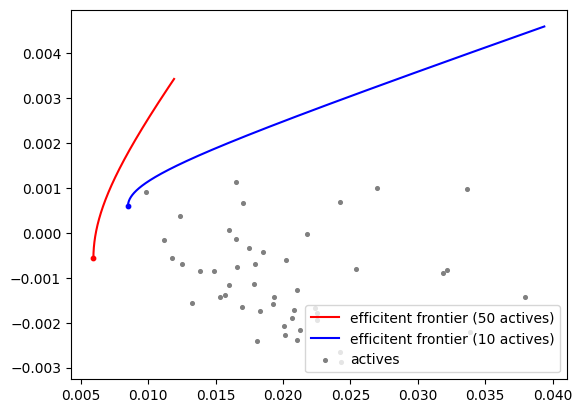

In [ ]:
fig, ax = plt.subplots()

# Эффективный фронт при 47 активах
plt.plot(x_short, y_short, color="red", label = "efficitent frontier (47 actives)")
plt.scatter(sigma_short, mean_short, s=10, color = "red")

# Эффективный фронт при 10 активах
plt.plot(x_short_10, y_short_10, color="blue", label = "efficitent frontier (10 actives)")
plt.scatter(sigma_short_10, mean_short_10, s=10, color = "blue")

# Активы
plt.scatter(summary_stats['std'], summary_stats['mean'], color = "grey", s=7, label = "actives")

plt.legend(loc = "lower right")
plt.show()



---


Как можно увидеть из графика выше, эффективные фронты довольно сильно отличаются друг от друга - в случае 10 активов эффективный фронт проходит ближе к активам. Это означает, что эти 10 активов не достаточно описывают все 47 активов, чтобы эффеквтиные фронты совпадали, по крайней мере в случае разрешения коротких продаж.


---



Проделаем то же самое при запрете коротких продаж

In [ ]:
#Эффективный фронт при запрете коротких продаж 10 акций
x_no_short_10, y_no_short_10 = efficient_frontier_no_short(mean_no_short_10, 10, 5000, means_10, cov_matrix_10)

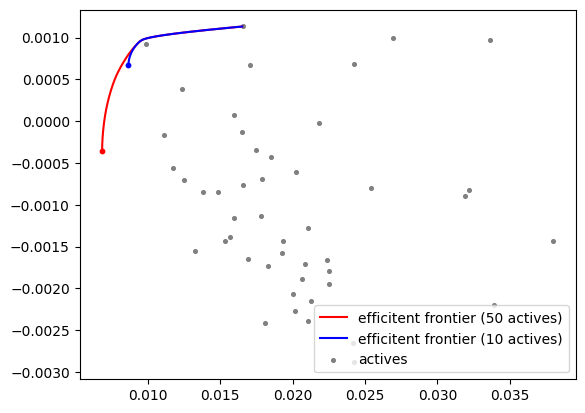

In [ ]:
fig, ax = plt.subplots()

# Эффективный фронт при 47 активах
plt.plot(x_no_short, y_no_short, color="red", label = "efficitent frontier (47 actives)")
plt.scatter(sigma_no_short, mean_no_short, s=10, color = "red")

# Эффективный фронт при 10 активах
plt.plot(x_no_short_10, y_no_short_10, color="blue", label = "efficitent frontier (10 actives)")
plt.scatter(sigma_no_short_10, mean_no_short_10, s=10, color = "blue")

# Активы
plt.scatter(summary_stats['std'], summary_stats['mean'], color = "grey", s=7, label = "actives")

plt.legend(loc = "lower right")
plt.show()



---


Здесь можно увидеть, что в отличие от случая с разрешением коротких продаж, эффективные фронты совпадают, хоть и не сразу, что говорит о том, что выбранные активы достаточно хорошо описывают остальные 47 активов.


---





---

По этой части задания можно сделать общий вывод, что рациональность решения о выборе 10 самых доходных активов зависит от выбранной стратегии: если не рассматривать короткие продажи, то самые доходные активы будут достаточно описывать все остальные, однако если короткие продажи разрешены, то подобная стратегия работает не очень хорошо и стоит рассмотреть другую вариацию выбора активов.

---




## 4. Отношение к риску

В этой части задания нам нужно найти оптимальные портфели относительно нашего отношения к риску и оценить их с помощью VaR и CVaR. Для начала напишем функции для вычисления VaR и CVaR.

In [ ]:
CONFIDENCE_LEVEL = 0.95


def calc_var(log_returns):
    return -np.percentile(log_returns, (1 - CONFIDENCE_LEVEL) * 100)


def calc_cvar(log_returns, var):
    return log_returns[log_returns >= var].mean()

Теперь найдем портфели с минимальным риском. В нашей модели значение отношения к риску определяет наклон касательной к эффективному фронту. Чтобы найти положение касательной, мы будем максимизировать функцию относительно доходности и минимизировать относительно риска (берем риск со знаком минуса). Полученные таким образом значения доходности и риска, зависящие от долей акций в портфеле, и будут являться оптимальными.

Напишем соответствующую функцию

In [ ]:
def calc_optimal_portfolio(weights, constraints, means, cov_matrix, risk_aversion):
  portfolio_return = means.T @ weights
  portfolio_risk = cp.quad_form(weights, cov_matrix)

  func = cp.Maximize(portfolio_return - (risk_aversion / 2) * portfolio_risk)
  problem = cp.Problem(func, constraints)
  problem.solve()

  return portfolio_return.value[0], np.sqrt(portfolio_risk.value)

Теперь выберем отношение к риску. Здесь значения от 1 до 2 отображают слабое отношение к риску, иначе говоря, риск здесь самый высокий, но и доходность так же выше, в сравнении с другими значениями. Между значениями 2 и 5 отношение к риску среднее - этот диапазон предпочитает большинство инвесторов, так как здесь достаточно хороший доход при допустимом риске. Если же рассматривать значения больше 5, то здесь риск самый маленький и становится меньше с увеличением отношения к риску. В теории это значение может быть увеличено до бесконечности, но на практике зачастую это не имеет смысла, так как с уменьшением риска, уменьшается и доходность, поэтому значения выше 10 или 15 обычно не берут, ведь доход в таком случае слишком низкий.

Мы же выберем среднее значение риска, так как подобное значение чаще всего встречается на практике и имеет самые оптимальные доходность и риск. Другие значения либо слишком рискованные и не стоят того риска, который они несут, либо имеют слишком низкую доходность.

In [ ]:
risk_aversion = 4

Найдем оптимальный портфель при разрешенных коротких продажах

In [ ]:
weights_short = cp.Variable(number)
constraints_short = [cp.sum(weights_short) == 1]
optimal_return_short, optimal_risk_short = calc_optimal_portfolio(weights_short, constraints_short, means, cov_matrix, risk_aversion)
optimal_weights_short = weights_short.value

print(f"Доходность оптимального портфеля: {optimal_return_short:.6f}")
print(f"Волатильность оптимального портфеля: {optimal_risk_short:.6f}")
print()
print("Доли акций в оптимальном портфеле:")
optimal_portfolio_short = dict(zip(returns.columns, optimal_weights_short))
for ticker, prop in optimal_portfolio_short.items():
  print(f"{ticker}: {prop:.6f}")
print(f"\nСумма долей активов в портфеле: {sum(optimal_portfolio_short.values())}")

Доходность оптимального портфеля: 0.036855
Волатильность оптимального портфеля: 0.096908

Доли акций в оптимальном портфеле:
1U1.DE: 0.558380
AAD.DE: 0.893051
ADN1.DE: 0.540537
AFX.DE: 2.105107
AIXA.DE: -0.167007
AT1.DE: 0.940965
BC8.DE: 0.320325
BFSA.DE: 0.657192
BOSS.DE: -0.952655
DHER.DE: 0.828375
ECV.DE: 1.323937
EVD.DE: 0.764261
EVT.DE: 0.334885
FNTN.DE: -1.914000
FPE3.DE: 0.164125
FRA.DE: -3.267154
FRE.DE: -0.150468
G1A.DE: -0.497083
G24.DE: 1.692994
GBF.DE: -1.534934
GXI.DE: -0.039043
HFG.DE: -1.165459
HLE.DE: 0.274438
HOT.DE: 0.227647
JEN.DE: 0.477425
JUN3.DE: -0.087631
KGX.DE: -0.287402
KRN.DE: -0.492853
LEG.DE: -2.857005
LHA.DE: -0.189158
NDA.DE: -1.622019
NDX1.DE: 0.202221
NEM.DE: 0.343557
PUM.DE: 0.446240
RAA.DE: 0.545619
RDC.DE: 0.143129
RRTL.DE: -0.571776
SAX.DE: -0.929819
SDF.DE: 0.796008
STM.DE: 0.337941
TEG.DE: 5.239712
TKA.DE: -0.199393
TLX.DE: 0.910027
TUI1.DE: -0.379932
UTDI.DE: -1.841287
WAF.DE: 0.477020
WCH.DE: -1.399039

Сумма долей активов в портфеле: 0.99999999



---


Из долей активов выше видно, что имеется зависимость от доходности акции за рассмотренный период: чем больше доходность актива, тем выше его доля в портфеле. Однако самую высокую долю имеет TEG.DE (*компания по недвижимости, основное внимание уделяется приобретению, развитию и управлению жилой недвижимостью, особенно на севере и востоке Германии*), в то время как самую высокую доходность - AFX.DE (*международная компания в области медицинских технологий, которая производит инструменты для офтальмологических исследований и медицинские лазеры, а также решения для нейрохирургии, стоматологии, гинекологии и онкологии*). Это объясняется нашим отношением к риску: так как мы выбрали среднее его значение, то риск имеет значимую роль в определении портфеля. Также можно отметить, что некоторые акции, такие как, например, ADN1.DE (*публично торгуемая консалтинговая и ИТ-компания*), TLX.DE (*страховая и перестраховочная компания*) и BFSA.DE (*люксембургская сервисная компания, предлагающая полный спектр услуг по утилизации отходов сталелитейной и алюминиевой промышленности*), имеют отрицательную доходность, однако они берутся с положительной долей в портфеле. Это снова объясняется выбранным отношением к риску: хоть эти активы и имеют низкую, даже отрицательную, доходность, у них так же и низкая волатильность, что своего рода балансирует их. Выбрав, например, более высокое значение отношения риску (слабая неприязнь к риску), эти активы имели бы отрицатльную долю, так как их волатильность не имела бы столь большого влияния.


---



Теперь посчитаем значения VaR и CVaR для этого портфеля

In [ ]:
returns_optimal_short = np.array([optimal_weights_short[i] * means[i] for i in range(number)])

VaR_optimal_short = calc_var(returns_optimal_short)
CVaR_optimal_short = calc_cvar(returns_optimal_short, VaR_optimal_short)

print(f'VaR:  {VaR_optimal_short:.6f}\nCVaR: {CVaR_optimal_short:.6f}')

VaR:  0.000922
CVaR: 0.002807


Отобразим портфель на графике относительно эффективного фронта

In [ ]:
# Пересчитываем эффективный фронт с большим кол-вом итераций
x_temp, y_temp = efficient_frontier_short(mean_short, number, 4000, means, cov_matrix, EPS_SHORT)

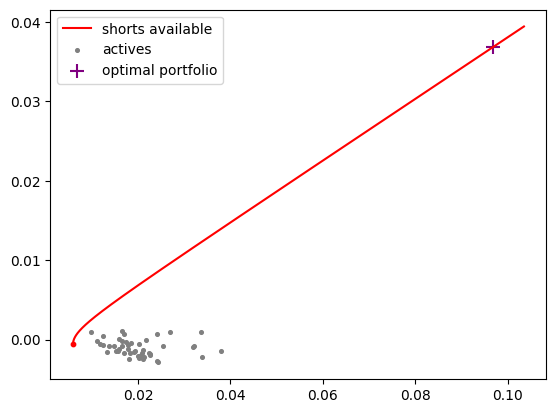

In [ ]:
fig, ax = plt.subplots()

# Короткие продажи разрешены
plt.scatter(sigma_short, mean_short, s=10, color = "red")
ax.plot(x_temp, y_temp, color = "red", label = "shorts available")

# Активы
plt.scatter(summary_stats['std'], summary_stats['mean'], color = "grey", s=7, label="actives")

# Оптимальный портфель
plt.scatter(optimal_risk_short, optimal_return_short, s=90, color = "purple", marker = "+", label = "optimal portfolio")

plt.legend()
plt.show()

То же самое проделаем и в случае запрета коротких продаж

In [ ]:
weights_no_short = cp.Variable(number)
constraints_no_short = [cp.sum(weights_no_short) == 1,
                        weights_no_short >= 0]
optimal_return_no_short, optimal_risk_no_short = calc_optimal_portfolio(weights_no_short, constraints_no_short, means, cov_matrix, risk_aversion)
optimal_weights_no_short = weights_no_short.value

print(f"Доходность оптимального портфеля: {optimal_return_no_short:.6f}")
print(f"Волатильность оптимального портфеля: {optimal_risk_no_short:.6f}")
print()
print("Доли акций в оптимальном портфеле:")
optimal_portfolio_no_short = dict(zip(returns.columns, optimal_weights_no_short))
for ticker, prop in optimal_portfolio_no_short.items():
    if prop >= 1e-16:
      print(f"{ticker}: {prop:.6f}")
print(f"\nСумма долей активов в портфеле: {sum(optimal_portfolio_no_short.values())}")

Доходность оптимального портфеля: 0.000997
Волатильность оптимального портфеля: 0.010077

Доли акций в оптимальном портфеле:
AFX.DE: 0.365578
TEG.DE: 0.634422

Сумма долей активов в портфеле: 0.9999999999999996




---

Из всех 47 активов остались всего два: AFX.DE (*международная компания в области медицинских технологий, которая производит инструменты для офтальмологических исследований и медицинские лазеры, а также решения для нейрохирургии, стоматологии, гинекологии и онкологии*) и TEG.DE (*компания по недвижимости, основное внимание уделяется приобретению, развитию и управлению жилой недвижимостью, особенно на севере и востоке Германии*). При этом, несмотря на то, что самую большую доходность имеет AFX.DE, TEG.DE имеет заметно большую долю в портфеле. Подобное поведение можно объяснить тем, что волатильность TEG.DE намного ниже AFX.DE (примерно на 0.007), а доходность у AFX.DE не так сильно превосходит TEG.DE (разница всего 0.0002). Засчет разницы в риске, TEG.DE и получил большую долю. Стоит отметить, что выбрав другое отношение к риску, например отражающее слабое отношение к риску (значения выше 5), то доля TEG.DE не была бы такой большой, потому что значимость риска для нас была бы уже не так важна.

---



Найдем значения VaR и CVaR

In [ ]:
returns_optimal_no_short = np.array([(optimal_weights_no_short[i] * means[i]) for i in range(number) if optimal_weights_no_short[i] > 1e-16])

VaR_optimal_no_short = -calc_var(returns_optimal_no_short)
CVaR_optimal_no_short = calc_cvar(returns_optimal_no_short, -VaR_optimal_no_short)

print(f'VaR:  {VaR_optimal_no_short:.6f}\nCVaR: {CVaR_optimal_no_short:.6f}')

VaR:  0.000422
CVaR: 0.000498


Выведем полученные данные

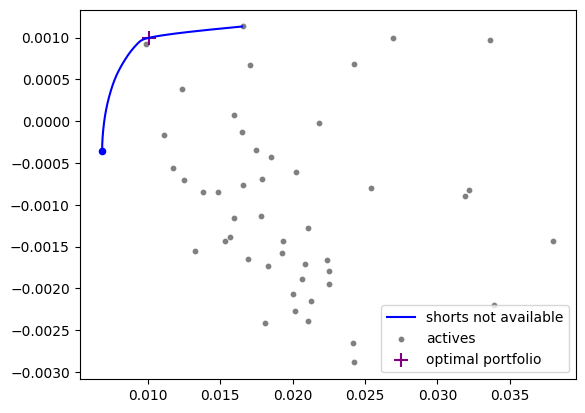

In [ ]:
fig, ax = plt.subplots()

# Короткие продажи запрещены
plt.scatter(sigma_no_short, mean_no_short, s=20, color = "blue")
ax.plot(x_no_short, y_no_short, color = "blue", label = "shorts not available")

# Активы
plt.scatter(summary_stats['std'], summary_stats['mean'], color = "grey", s=10, label="actives")

# Оптимальный портфель
plt.scatter(optimal_risk_no_short, optimal_return_no_short, s=90, color = "purple", marker = "+", label = "optimal portfolio")

plt.legend()
plt.show()